A Bank organizes marketing campaigns to inform people about their deposit plans and to increase their subscribers of these plans. These campaigns typically involve telephone calls to a large number of people, and based on their dataset, they are then approached one by one to get them on board with their deposit plan.

The dataset contains some customer information (such as age, job, and so on) and campaign-related information (such as contact or communication type, day, month, and duration of the contact).

For the next marketing campaign, the bank wants to use this data and only contact potential customers who will subscribe to the term deposit, thereby reducing the effort needed to contact those customers who are not interested.

In [32]:
# Removes Warnings
import warnings 
warnings.filterwarnings('ignore') 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bank = pd.read_csv('/content/drive/MyDrive/Marketing-Analytics/Data/bank.csv', sep = ';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
bank = bank.rename(columns={'y': 'Target'})

In [5]:
bank['Target']=bank['Target'].replace({'no': 0, 'yes': 1})

In [6]:
bank.shape

(4334, 17)

In [7]:
bank.isnull().values.any()

False

In [8]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous,Target
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,40.991924,1410.637517,15.913936,264.544301,2.806876,39.670974,0.544070,0.115828
std,10.505378,3010.612091,8.216673,260.642141,3.129682,99.934062,1.702219,0.320056
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,67.000000,9.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,440.000000,16.000000,186.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1464.000000,21.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


In [9]:
bank.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,4334,4334,4334,4334,4334,4334,4334,4334,4334
unique,12,3,3,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,942,2680,2306,4261,2476,3650,2801,1339,3555


In [10]:
bank['Target'].value_counts(0)

0    3832
1     502
Name: Target, dtype: int64

In [12]:
# value counts as percentage
bank['Target'].value_counts(1)*100

0    88.417167
1    11.582833
Name: Target, dtype: float64

In [14]:
bank['job'].value_counts()

management       942
blue-collar      905
technician       746
admin.           461
services         404
retired          216
self-employed    179
entrepreneur     157
unemployed       126
housemaid        107
student           68
unknown           23
Name: job, dtype: int64

In [17]:
bank['marital'].value_counts()

married     2680
single      1150
divorced     504
Name: marital, dtype: int64

In [16]:
bank['education'].value_counts()

secondary    2306
tertiary     1350
primary       678
Name: education, dtype: int64

In [18]:
bank['default'].value_counts()

no     4261
yes      73
Name: default, dtype: int64

In [19]:
bank['housing'].value_counts()

yes    2476
no     1858
Name: housing, dtype: int64

In [20]:
bank['loan'].value_counts()

no     3650
yes     684
Name: loan, dtype: int64

In [21]:
bank['contact'].value_counts()

cellular     2801
unknown      1251
telephone     282
Name: contact, dtype: int64

In [22]:
bank['poutcome'].value_counts()

unknown    3555
failure     471
other       189
success     119
Name: poutcome, dtype: int64

In [23]:
bank["job"] = bank["job"].astype('category').cat.codes
bank["marital"] = bank["marital"].astype('category').cat.codes
bank["education"] = bank["education"].astype('category').cat.codes
bank["default"] = bank["default"].astype('category').cat.codes
bank["housing"] = bank["housing"].astype('category').cat.codes
bank["loan"] = bank["loan"].astype('category').cat.codes
bank["contact"] = bank["contact"].astype('category').cat.codes
bank["poutcome"] = bank["poutcome"].astype('category').cat.codes

In [24]:
bank['education'] = bank['education'].replace({'primary': 0, 'secondary': 1, 'tertiary':2})

In [25]:
bank['month'].value_counts()

may    1339
jul     681
aug     618
jun     495
nov     377
apr     288
feb     213
jan     136
oct      75
sep      47
mar      47
dec      18
Name: month, dtype: int64

In [26]:
bank['month'].replace(['jan', 'feb', 'mar','apr','may','jun', 'jul','aug','sep','oct','nov','dec'],
            [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)

In [27]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,5,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,4,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,5,226,1,-1,0,3,0


In [28]:
target = 'Target'
X = bank.drop(['Target'], axis=1)
y=bank[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

In [29]:
y_train.value_counts()

0    3256
1     427
Name: Target, dtype: int64

In [30]:
y_test.value_counts()

0    576
1     75
Name: Target, dtype: int64

# Standardization

$ x^i (std) = \frac{x^i - \mu_x}{\sigma_x} $

 * $x^i$ - input data
 * $ \mu_x $ - mean
 * $\sigma_x$ - standard deviation

In [31]:
standard_scalar = StandardScaler()
X_train_sc = standard_scalar.fit_transform(X_train)
X_test_sc = standard_scalar.transform(X_test)

**Random Forest**

The  random forest  algorithm reduces variance/overfitting by averaging multiple decision trees, which individually suffer from high variance.

Random Forest Algorithm:
1. A random bootstrap sample (a sample drawn with replacement) of size m is chosen from the training data. This splits the training data into subsets such as Data1, Data2, and so on. 
2. Decision trees are grown on each instance of the bootstrap. These decision trees can be referred to as Learner1, Learner2, and so on. 
3. d features are chosen randomly without replacement. 
4. Each node is split using the d features selected based on objective functions, which could be information gain. 
5. Steps 1-4 are repeated k times. Eventually, this generates Model1, Model2, and so on for each subset.
6. All of the predictions from the multiple trees are aggregated and assigned a class label by majority vote.

The thumb rule for variable selection of m variables out of total variables p, is m = sqrt(p) for classification and m = p/3 for regression problems randomly to avoid correlation among the individual trees. By doing so, significant improvement in accuracies can be achieved.

In [33]:
clf_random = RandomForestClassifier(n_estimators=20,\
                max_depth=None,\
                min_samples_split=7,\
                random_state=0)

In [34]:
clf_random.fit(X_train_sc,y_train)

RandomForestClassifier(min_samples_split=7, n_estimators=20, random_state=0)

In [35]:
y_pred=clf_random.predict(X_test_sc)

In [36]:
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          No       0.93      0.97      0.95       576
         Yes       0.64      0.40      0.49        75

    accuracy                           0.90       651
   macro avg       0.78      0.69      0.72       651
weighted avg       0.89      0.90      0.89       651



Predicting potential customers that will subscribe is low. 

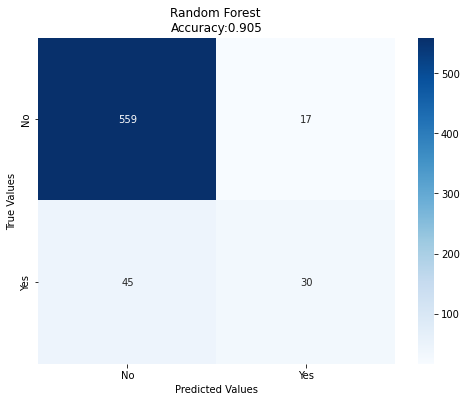

In [37]:
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,\
            index = ['No', 'Yes'],\
            columns = ['No', 'Yes'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Random Forest \nAccuracy:{0:.3f}'\
    .format(accuracy_score(y_test, y_pred)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

**Gradient Boosting**

Gradient boosting classifier works on the principle of boosting weak learners iteratively by shifting focus towards problematic observations that were difficult to predict in previous iterations and performing an ensemble of weak learners, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, but generalizes them by allowing optimization of an arbitrary differentiable loss function.

Gradient boosting steps:
  1. fit the model on observations producing $P_0$% accuracy; the remaining unexplained variance is captured in the error term: $Y = F(x) + error$
  2. fit another model on the error term to pull the extra explanatory component and add it to the original model, which should improve the overall accuracy: $error = G(x) + error2$
  3. the model will improve to $P_1$% accuracy and the equation looks as follows: $Y = F(x) + G(x) + error2$
  4. continue this method one more time to fit a model on the $error2$ component to extract a further explanatory component: $error2 = H(x) + error3$
  5. model accuracy is again improved to $P_2$% and the final model equation looks as follows: $Y = F(x) + G(x) + H(x) + error3$
  6. Gradient boosting improves results further by using weighted average (higher importance given to better models that predict results with greater accuracy than others) $Y = a*G(x) + B*G(x) + 𝛶*H(x) + error4$

Gradient boosting involves three elements:
 * Loss function to be optimized: Loss function depends on the type of problem being solved. In the case of regression problems, mean squared error is used, and in classification problems, logarithmic loss will be used. In boosting, at each stage, unexplained loss from prior iterations will be optimized rather than starting from scratch.
 * Weak learner to make predictions: Decision trees are used as a weak learner in gradient boosting.
 * Additive model to add weak learners to minimize the loss function: Trees are added one at a time and existing trees in the model are not changed. The gradient descent procedure is used to minimize the loss when adding trees.

Gradient Boosting Algorithm:
 1. Initialize: initializes the constant optimal constant model, which is just a single terminal node that will be utilized as a starting point to tune it further in next steps. $f_0(x) = argmin_y \sum^{N}_{i=1}L(y_i,𝛶)$
 2. For m = 1 to M:
  * For i = 1, 2, …, N compute: calculate the residuals/errors by comparing actual outcome with predicted results $ 𝑟_{im} = -[\frac{∂L(y_i,f(x_i))}{∂f(x_i)} ]f = f_{m-1}$
  * Fit a regression tree to the targets $r_{im}$ giving terminal regions $R_{jm}$, $j$ = 1, 2, …, $J_m$: the next decision tree will be fitted on error terms to bring in more explanatory power to the model. 
  * For $j$ = 1, 2, …, $J_m$, compute: the next decision tree will be fitted on error terms to bring in more explanatory power to the model $ 𝛶_{jm} = argmin_{𝛶} \sum_{x_i \in R_{jm}} L(y_i, f_{m-1}(x_i)+𝛶) $
  * d) Update: add the extra component to the model at last iteration. $ f_m(x) = f_{m-1}(x) + ∑^{J_m}_{j=1} 𝛶_{jm}I(x \in R_{jm}) $
 3. Output: ensemble all weak learners to create a strong learner. $ \hat{f}(x) = f_m(x) $ 


In [38]:
Gbr = GradientBoostingClassifier().fit(X_train_sc,y_train)

In [39]:
y_pred2=Gbr.predict(X_test_sc)

In [40]:
print(classification_report(y_test, y_pred2, target_names=target_names))

              precision    recall  f1-score   support

          No       0.92      0.98      0.95       576
         Yes       0.67      0.39      0.49        75

    accuracy                           0.91       651
   macro avg       0.80      0.68      0.72       651
weighted avg       0.90      0.91      0.90       651



Gradient Boosting and Random Forest performed very similar

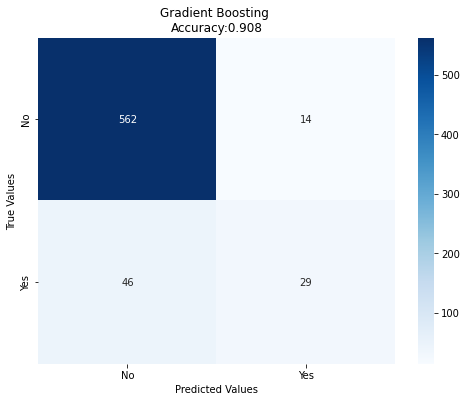

In [41]:
cm2 = confusion_matrix(y_test, y_pred2) 

cm_df2 = pd.DataFrame(cm2,\
            index = ['No', 'Yes'],\
            columns = ['No', 'Yes'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df2, annot=True,fmt='g',cmap='Blues')
plt.title('Gradient Boosting \nAccuracy:{0:.3f}'\
    .format(accuracy_score(y_test, y_pred2)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

**Synthetic Minority Oversampling Technique (SMOTE)**
* A subset of the minority class data is taken, and a similar replica of the data is created, which is added to the main datasets. This method helps increase the model accuracy on imbalanced data. 

In [42]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train,y_train)

In [43]:
standard_scalar = StandardScaler()
X_train_sc_resampled = standard_scalar.fit_transform(X_resampled)
X_test_sc = standard_scalar.transform(X_test)

In [44]:
clf_random.fit(X_train_sc_resampled,y_resampled)

RandomForestClassifier(min_samples_split=7, n_estimators=20, random_state=0)

In [45]:
y_pred=clf_random.predict(X_test_sc)

In [46]:
target_names = ['No', 'Yes']
print(classification_report(y_test, y_pred,\
            target_names=target_names))

              precision    recall  f1-score   support

          No       0.95      0.90      0.92       576
         Yes       0.43      0.60      0.50        75

    accuracy                           0.86       651
   macro avg       0.69      0.75      0.71       651
weighted avg       0.89      0.86      0.87       651



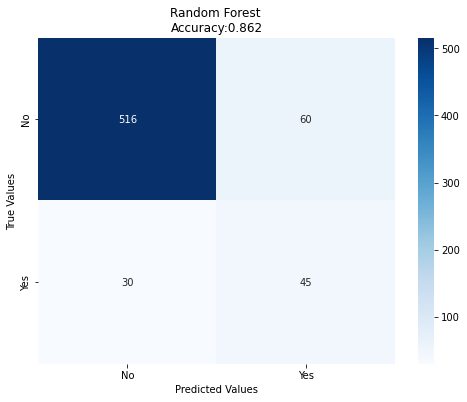

In [48]:
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,\
            index = ['No', 'Yes'],\
            columns = ['No', 'Yes'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Random Forest \nAccuracy:{0:.3f}'\
    .format(accuracy_score(y_test, y_pred)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

The SMOTE method improved the recall rate.  